# How I made my models and tested their accuracy

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json, string

from helper_functions import movies_matrix, vectorize, htmltostring, print_top_words
from profit_curve import smote, oversample, undersample
from roc_curve import roc_curve
from clean_df import cleaned_data

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

## Loading data
After collecting data using Goodreads API, load the json file and turn it into a pandas dataframe.

In [2]:
with open('goodreads_data2') as f:
    data2 = [json.loads(line) for line in f]
    
with open('goodreads_data3') as f:
    data3 = [json.loads(line) for line in f]

with open('goodreads_data4') as f:
    data4 = [json.loads(line) for line in f]
    
with open('goodreads_data5') as f:
    data5 = [json.loads(line) for line in f]

with open('goodreads_data6') as f:
    data6 = [json.loads(line) for line in f]

df = pd.DataFrame(data2+data3+data4+data5+data6)
new_df = df.drop_duplicates(subset=['author','title'],keep='first')

clean_data = cleaned_data(new_df)

## Exploratory Data Analysis - Out of Box

As this is imbalanced class, analysis has to rely on other performance metrics such as precision and recall. First, take a look at Logistic Regression, RandomForest, and GradientBoosting.

Consider the following:
- True Positive: Have Movie/Have Movie
- False Positive: Have Movie/Doesn't Have Movie
- False Negative: Doesn't Have Movie/Have Movie
- True Negative: Doesn't Have Movie/Doesn't Have Movie

I care about maximizing True Positives and minimizing False Negatives as I do not want to incorrectly identify the books that have movies as not having movies. The most interesting case is False Positives as these books are possibly identified to have a movie, but sometime in the future.

Therefore, my goal is to increase recall as high as possible.

In [10]:
X = clean_data.drop(['has_movie','year'],axis=1)
y = clean_data['has_movie']

Accuracy: 0.9391727493917275
Precision: 0.5319148936170213
Recall: 0.07621951219512195
F1 Score: 0.13333333333333333
ROC AUC Score: 0.5359163363567833


Confusion matrix, without normalization
[[  25   22]
 [ 303 4993]]


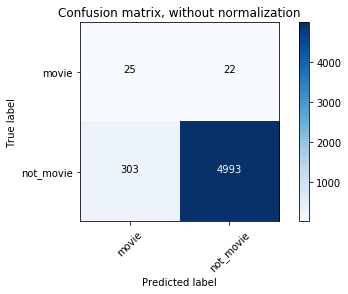

In [20]:
#Logistic Regression
log = LogisticRegression()
movies_matrix(log,X,y)

The beta coefficients provides the change in odds ratio.

In [21]:
# Look at beta coefficients
for name, coef in zip(list(X.columns),log.coef_[0]):
    print("{}: {}".format(name,coef))

death_date: 0.7006061434348078
female: 0.025778149493576884
male: 0.23460760511052603
is_series: -0.25983276039166014
biography: -0.45909256998437625
autobiography: -0.20961667270620618
science_fiction: 0.10409250626157068
romance: 0.022185928622352122
is_classic: 1.5348943834791702
comedy: 0.1399381317687974
coming-of-age: 0.5211534251127993
fantasy_fiction: -0.1890395820867559
mystery_fiction: 0.010186511844549273
dystopian_future: 0.2658645619486186
historical_fiction: 0.3163354220343446
realistic-fiction: 0.5422670938837251
drama: 0.6246578152712066
horror: 0.21469861871234444
crime: 0.07596404742643907
suspense: 0.4773355367653513
paranormal: 0.191856708400664
thriller: 0.4830060318908786
war: 0.14955469660196938
contemporary: 0.29296000814379264
chick-lit: 0.026606460963149402
action: 0.02405921565080803
young_adult: 0.22949823423298282
adult: 0.44754166909506954
animals: 0.4000911925244074
action: 0.02405921565080803
childrens_fiction: 0.23035608540002375
avg_rating: 0.235118106

Accuracy: 0.9346808908852704
Precision: 0.4111111111111111
Recall: 0.1111111111111111
F1 Score: 0.1749408983451537
ROC AUC Score: 0.550266134397871


Confusion matrix, without normalization
[[  37   53]
 [ 296 4957]]


Text(0,0.5,'Features')

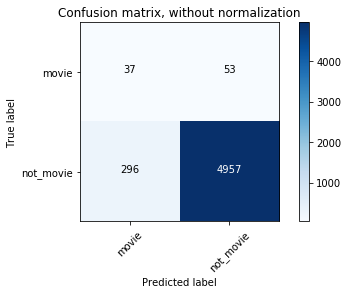

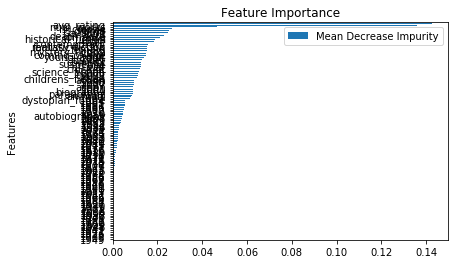

In [24]:
rfc = RandomForestClassifier()
movies_matrix(rfc,X,y)
feat_scores = pd.DataFrame({'Mean Decrease Impurity': rfc.feature_importances_},
                          index=X.columns)
feat_scores = feat_scores.sort_values(by='Mean Decrease Impurity')
feat_scores.plot(kind='barh', title='Feature Importance')
plt.ylabel('Features')

Accuracy: 0.9408571963316489
Precision: 0.7142857142857143
Recall: 0.06097560975609756
F1 Score: 0.11235955056179776
ROC AUC Score: 0.5296901976995841


Confusion matrix, without normalization
[[  20    8]
 [ 308 5007]]


Text(0,0.5,'Features')

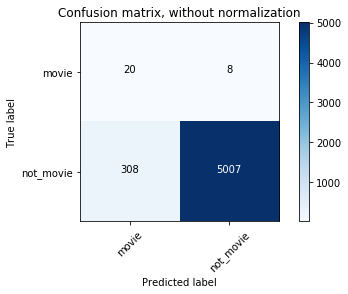

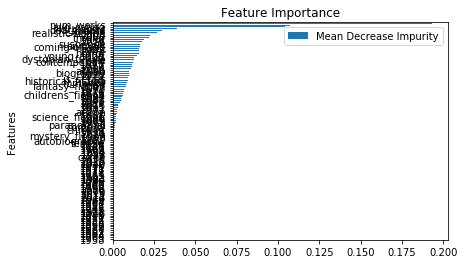

In [27]:
gbc = GradientBoostingClassifier()
movies_matrix(gbc,X,y)

feat_scores = pd.DataFrame({'Mean Decrease Impurity': gbc.feature_importances_},
                          index=X.columns)
feat_scores = feat_scores.sort_values(by='Mean Decrease Impurity')
feat_scores.plot(kind='barh',title='Feature Importance')
plt.ylabel('Features')

# Exploratory Data Analysis - Hyperparameter Tuning

I will use sklearn's GridSearchCV to tune the hyperparameters of my model(s). My goal is to see if my recall improves.

In [28]:
#Logisitc Regression Classifier
param_grid = {'class_weight':[None,'balanced'],
             'C':[0.001,0.01,0.1,1.0,1.1]}
lr = LogisticRegression()
cv_lr = GridSearchCV(estimator=lr,param_grid=param_grid,cv=5)
cv_lr.fit(X,y)
print(cv_lr.best_params_)

{'C': 1.0, 'class_weight': None}


While class_weight was returned None, the documentation suggested to use "balanced" when you have an imbalanced class.

Accuracy: 0.7450870297585626
Precision: 0.16536964980544747
Recall: 0.7727272727272727
F1 Score: 0.27243589743589747
ROC AUC Score: 0.7579973886078015


Confusion matrix, without normalization
[[ 255 1287]
 [  75 3726]]


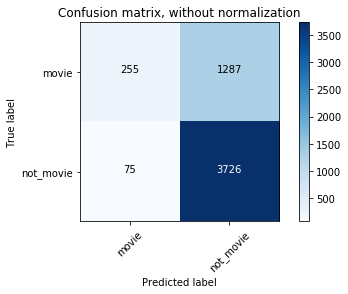

In [29]:
X = clean_data.drop(['has_movie','year'],axis=1)
y = clean_data['has_movie']

#Logistic Regression
log = LogisticRegression(C=1.0,class_weight='balanced')
movies_matrix(log,X,y)

In [34]:
param_grid = {'max_features': ['auto','sqrt','log2'],
             'class_weight': [None,'balanced']}
rfc = RandomForestClassifier()
cv_rfc = GridSearchCV(rfc,param_grid=param_grid,cv=5)
cv_rfc.fit(X,y)
print(cv_rfc.best_params_)

{'class_weight': 'balanced', 'max_features': 'auto'}


Accuracy: 0.9358038555118847
Precision: 0.4742268041237113
Recall: 0.13609467455621302
F1 Score: 0.2114942528735632
ROC AUC Score: 0.5629524321832013


Confusion matrix, without normalization
[[  46   51]
 [ 292 4954]]


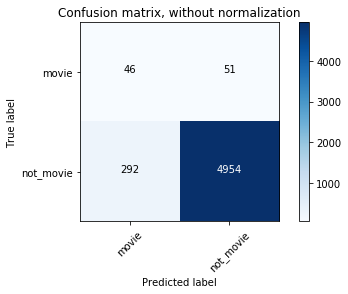

In [35]:
rfc = RandomForestClassifier(class_weight='balanced')
movies_matrix(rfc,X,y)

In [31]:
param_grid = {'loss' : ['deviance', 'exponential'],
             'max_features': ['auto','sqrt','log2']}
gbc = GradientBoostingClassifier()
cv_gb = GridSearchCV(gbc,param_grid=param_grid,cv=5)
cv_gb.fit(X,y)
print(cv_gb.best_params_)

{'loss': 'exponential', 'max_features': 'sqrt'}


Accuracy: 0.9373011416807038
Precision: 0.45
Recall: 0.02702702702702703
F1 Score: 0.05099150141643059
ROC AUC Score: 0.512415709122296


Confusion matrix, without normalization
[[   9   11]
 [ 324 4999]]


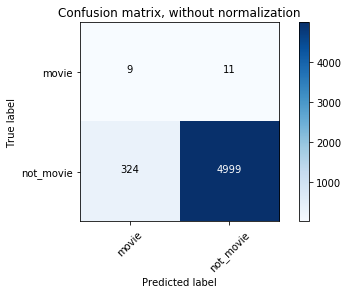

In [32]:
gbc = GradientBoostingClassifier(loss='exponential',max_features='sqrt')
movies_matrix(gbc,X,y)

The best performing model so far is Logisitic Regression with the highest recall score. From this point forward, I'll be working with Logistic Regression.

To counteract the negative effects class imbalance can cause on my models, I will use sampling methods -- undersampling, oversampling, and SMOTE.

Accuracy: 0.7304884896125772
Precision: 0.15422885572139303
Recall: 0.7560975609756098
F1 Score: 0.256198347107438
ROC AUC Score: 0.7424555601488219


Confusion matrix, without normalization
[[ 248 1360]
 [  80 3655]]


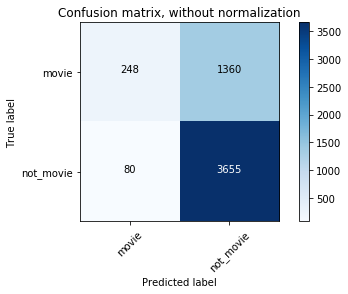

In [37]:
years = pd.get_dummies(clean_data.year)
years_columns = list(years.columns)
X = clean_data.drop(['has_movie','year','avg_rating','num_works']+years_columns,axis=1)
y = clean_data['has_movie']

#Logistic Regression
log = LogisticRegression(C=1.0,class_weight='balanced')
movies_matrix(log,X,y)

In [38]:
# Look at beta coefficients
for name, coef in zip(list(X.columns),log.coef_[0]):
    print("{}: {}".format(name,coef))

death_date: 0.6279150739962147
female: 0.4469666391823876
male: 0.8031670346072338
is_series: -0.24858964882416265
biography: -0.4904870434077364
autobiography: -0.24842403250235617
science_fiction: -0.2002401857703238
romance: -0.11334563238200723
is_classic: 1.5127734303706526
comedy: 0.16275873086064235
coming-of-age: 0.38999439048929235
fantasy_fiction: -0.023367345949804066
mystery_fiction: -0.014505445994170498
dystopian_future: 0.46168337618851124
historical_fiction: 0.33608366611741997
realistic-fiction: 0.49965609381683984
drama: 0.7105987999566213
horror: 0.29038631458533226
crime: -0.057588359304790844
suspense: 0.5492774334166882
paranormal: 0.12253703086589379
thriller: 0.49402378680203396
war: -0.12580524689212902
contemporary: 0.529385058785032
chick-lit: 0.09077950696650006
action: 0.07929257021881136
young_adult: 0.3203681467958794
adult: 0.17758292849336227
animals: 0.3767249164763327
action: 0.07929257021881136
childrens_fiction: 0.23815022165027663


While our metrics returned promising results, there are features we have not explored--one being the text. I will now take a dive into NLP on the description of the books.

# Use WordVectorizer on description of books

In [40]:
def tokenize_wordnet(doc):
    '''
    INPUT: string
    OUTPUT: list of strings
    Tokenize and stem/lemmatize the document.
    '''
    wordnet = WordNetLemmatizer()
    return [wordnet.lemmatize(word) for word in word_tokenize(doc)]

def update_desc(descriptions):
    '''
    INPUT: document
    OUTPUT: cleaned document
    '''
    update_desc = []
    for each in descriptions:
        tokens = [w.lower() for w in word_tokenize(each)] #split int words and convert to lowercase
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens] # remove punctuation from each word
        words = [word for word in stripped if word.isalpha()] # remove remaining tokens that are not alphabetic
        update_desc.append(' '.join(words))
    return update_desc

In [41]:
descriptions = htmltostring(new_df,'description')
update_desc = update_desc(descriptions)
vect = TfidfVectorizer(stop_words='english',max_df=0.95, 
                       min_df=2,max_features=1000,tokenizer=tokenize_wordnet)
desc_vect = vect.fit_transform(update_desc)
tfidf_feature_names = vect.get_feature_names()
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5).fit(desc_vect)
print_top_words(nmf, tfidf_feature_names, 20)

Topic #0: love life woman family story young mother child novel father daughter man home girl marriage year heart wife ha beautiful
Topic #1: la y el en que una los del su se e por al o di ha da era son il
Topic #2: und der die den zu da ist ein sich von sie mit eine auf er dem al e hat au
Topic #3: book story work reader edition classic american novel history writer s tale published author collection world written u life great
Topic #4: wa d knew did man year wanted came death took time thought woman murder born said went later met died
Topic #5: s murder ha killer case father death t mystery detective friend man crime just turn dead body sister police town
Topic #6: le et la à dans une qui du il ce en au que son plus se roman d grand di
Topic #7: world ha war power human dark secret force magic evil king battle enemy man earth ancient land powerful mysterious come
Topic #8: nt know doe want just thing ha ca like friend make school girl way life need ll t think little
Topic #9: new yo